In [1]:
import os
import codecs
import pandas as pd
import numpy as np
import warnings
import collections

# change dir for custom imports
os.chdir('../')
from scripts.dataset_downloader import initialize_dataset
from scripts.k_means import create_clsuters, clustering_errors
from scripts.helpers import get_most_rated_movies


dataset = 'ml-100k'
dataset_path = os.path.join('datasets', dataset)

In [ ]:
# If dataset hasn't been previously initialized, it can be done with this function
initialize_dataset(dataset)

In [289]:
ratings_path = os.path.join(dataset_path, 'u.data')
items_path = os.path.join(dataset_path, 'u.item')
genres_path = os.path.join(dataset_path, 'u.genre')
users_path = os.path.join(dataset_path, 'u.user')

ratings_file = codecs.open(ratings_path, 'rU', 'UTF-8')
items_file = codecs.open(items_path, 'rU', 'latin-1')
users_file = codecs.open(users_path, 'rU', 'latin-1')

# load data
ratings_df = pd.read_csv(ratings_file, sep='\t', names=('user_id', 'item_id', 'rating', 'timestamp'))
genres_df = pd.read_csv(genres_path, sep='|', names=('title', 'id'))

cols_names = ('id', 'title', 'year', 'nan', 'link') + tuple(genres_df.title.to_list())
items_df = pd.read_csv(items_file, sep='|', usecols=list(range(0,24)), names=cols_names).drop(columns=['nan', 'link'])

users_df = pd.read_csv(users_file, sep='|', usecols=list(range(0,4)), names=('user_id', 'age', 'gender', 'occupation'))

# dataset stats
print(f"Total dataset users: {len(set(ratings_df.user_id.to_list()))}")
print(f"Total dataset ratings: {len(ratings_df.user_id.to_list())}")

Total dataset users: 943
Total dataset ratings: 100000


In [250]:
ratings_df_detailed = pd.merge(ratings_df, items_df, left_on='item_id', right_on='id')
# ratings_df_detailed.groupby('user_id')['Action'].mean()

genres = genres_df.title.to_list()
for genre in genres:
    mean_genre = ratings_df_detailed.groupby('user_id')[genre].sum()
    users_df[genre] = mean_genre.values

users_df.drop(columns=['unknown'], inplace=True)

In [287]:
user_total_ratings = ratings_df.groupby(by="user_id")["rating"].count()
user_positive_ratings = ratings_df[ratings_df['rating'] > 3].groupby('user_id')['rating'].count().reset_index()
user_negative_ratings = ratings_df[ratings_df['rating'] <= 3].groupby('user_id')['rating'].count().reset_index()

# Update main df
users_df["ratings"] = user_total_ratings.values
users_df = pd.merge(users_df, user_positive_ratings, on=['user_id'], how='left').rename(columns={'rating':'positive_ratings'})
users_df = pd.merge(users_df, user_negative_ratings, on=['user_id'], how='left').rename(columns={'rating':'negative_ratings'})

# Clean none values
users_df.fillna(0, inplace=True)

In [288]:
users_df

,user_id,age,gender,occupation,ratings,positive_ratings,negative_ratings
0,1,24,M,technician,272,163.0,109.0
1,2,53,F,other,62,40.0,22.0
2,3,23,M,writer,54,15.0,39.0
3,4,24,M,technician,24,19.0,5.0
4,5,33,F,other,175,58.0,117.0
...,...,...,...,...,...,...,...
938,939,26,F,student,49,39.0,10.0
939,940,32,M,administrator,107,57.0,50.0
940,941,20,M,student,22,18.0,4.0
941,942,48,F,librarian,79,66.0,13.0


In [257]:
import gower

# Get the gower distance matrix
distance_matrix = gower.gower_matrix(users_df.drop(columns=['user_id']))

In [338]:
from sklearn.cluster import DBSCAN

# NOT USED, I used the linkage method below
# Configuring the parameters of the clustering algorithm
dbscan_cluster = DBSCAN(eps=1, # def=0.5
                        min_samples=2, # def=5
                        metric="euclidean")

# Fitting the clustering algorithm
dbscan_cluster.fit(distance_matrix)

# Adding the results to a new column in the dataframe
users_df["cluster"] = dbscan_cluster.labels_

counter = collections.Counter(users_df.cluster.to_list())
counter

Counter({5: 136,
         22: 68,
         25: 68,
         13: 64,
         9: 59,
         16: 59,
         -1: 49,
         4: 40,
         1: 36,
         17: 34,
         14: 28,
         6: 27,
         0: 26,
         3: 25,
         7: 25,
         10: 21,
         30: 18,
         15: 15,
         12: 13,
         2: 11,
         8: 10,
         28: 10,
         37: 10,
         20: 9,
         24: 9,
         29: 7,
         35: 6,
         41: 6,
         11: 4,
         21: 4,
         32: 4,
         42: 4,
         19: 3,
         23: 3,
         26: 3,
         27: 3,
         36: 3,
         38: 3,
         39: 3,
         44: 3,
         18: 2,
         31: 2,
         33: 2,
         34: 2,
         40: 2,
         43: 2,
         45: 2})

In [320]:
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import dendrogram

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=shc.ClusterWarning)
    # Compute linkage using the distance matrix
    linkage = shc.linkage(
        distance_matrix,
        # metric='precomputed',
        # method='average'
        method='ward'
    )

# Use fcluster to get the cluster labels
# `t` is the threshold to use to cut the dendrogram - higher `t` means less clusters / more data points within individual clusters
t = 8
clusters = shc.fcluster(linkage, t, criterion='distance')

# get unique cluster labels
unique_labels = np.unique(clusters)

# Adding the results to a new column in the dataframe
users_df["cluster_shc"] = clusters

print(f'Generated {len(unique_labels)} clusters.')

Generated 29 clusters.


In [321]:
counter = collections.Counter(users_df.cluster_shc.to_list())
counter

Counter({11: 116,
         27: 61,
         1: 60,
         13: 53,
         19: 49,
         17: 41,
         24: 38,
         9: 38,
         2: 36,
         3: 36,
         15: 35,
         14: 33,
         6: 29,
         28: 27,
         8: 27,
         4: 25,
         25: 24,
         29: 23,
         20: 23,
         23: 22,
         21: 20,
         22: 20,
         10: 20,
         26: 19,
         16: 19,
         7: 19,
         12: 16,
         18: 11,
         5: 3})

In [322]:
users_df

,user_id,age,gender,occupation,cluster,cluster_shc
0,1,24,M,technician,0,26
1,2,53,F,other,1,2
2,3,23,M,writer,2,27
3,4,24,M,technician,0,26
4,5,33,F,other,1,2
...,...,...,...,...,...,...
938,939,26,F,student,18,1
939,940,32,M,administrator,4,20
940,941,20,M,student,5,11
941,942,48,F,librarian,16,6


In [327]:
from kmodes.kprototypes import KPrototypes



C:\Users\wessa\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


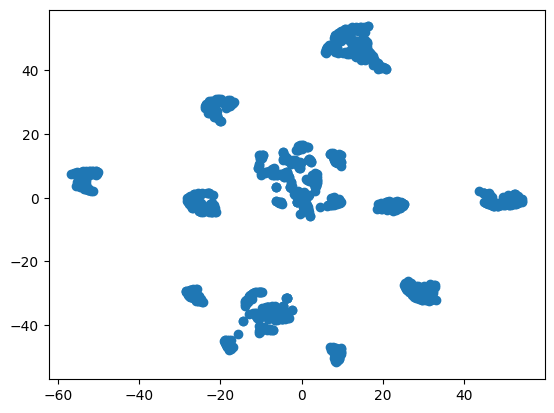

In [330]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Create a t-SNE object
tsne = TSNE(
    n_components=2,
    perplexity=30, # [5, 50] default is 30
    learning_rate=200, # [10.0, 1000.0] , def=200
    n_iter=1000, # >250, def=1000
    metric="euclidean"
)

# Perform t-SNE on the distance matrix
tsne_data = tsne.fit_transform(distance_matrix)
# test = tsne.fit(distance_matrix)

# Plot the t-SNE data using a scatter plot
plt.scatter(tsne_data[:, 0], tsne_data[:, 1])
plt.show()

In [ ]:
dn = dendrogram(linkage)

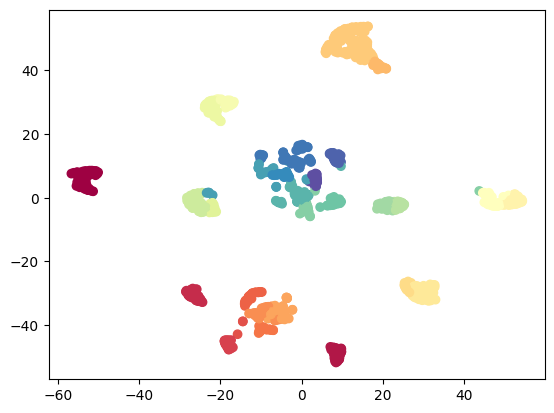

In [339]:
# Add the cluster labels to the t-SNE data
tsne_data_clusters = np.column_stack((tsne_data, clusters))

# Plot the t-SNE data using a scatter plot
plt.scatter(tsne_data_clusters[:, 0], tsne_data_clusters[:, 1], c=tsne_data_clusters[:, 2], cmap='Spectral')
plt.show()

In [ ]:
# Count the number of occurrences of each cluster label
num_points_per_cluster, counts = np.unique(clusters, return_counts=True)

# Print the number of points in each cluster
for cluster, count in zip(num_points_per_cluster, counts):
    print(f"Cluster {cluster}: {count} points")

In [ ]:
# Compute the average count
avg_count = np.mean(counts)
print(f"Average count per cluster: {round(avg_count)} users")

In [ ]:
from sklearn.decomposition import PCA

plotX = users_df
plotX

#PCA with two principal components
pca_2d = PCA(n_components=2)

#This DataFrame contains the two principal components that will be used
#for the 2-D visualization mentioned above
PCs_2d = pd.DataFrame(pca_2d.fit_transform(plotX.drop(["shc_cluster", "gender", "occupation"], axis=1)))
PCs_2d.columns = ["PC1_2d", "PC2_2d"]
plotX = pd.concat([plotX, PCs_2d], axis=1, join='inner')

cluster0 = plotX[plotX["shc_cluster"] == 1]
cluster1 = plotX[plotX["shc_cluster"] == 2]
cluster2 = plotX[plotX["shc_cluster"] == 3]

In [ ]:
#plotly imports
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

#Instructions for building the 2-D plot

#trace1 is for 'Cluster 0'
trace1 = go.Scatter(
                    x = cluster0["PC1_2d"],
                    y = cluster0["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 1",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = None)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter(
                    x = cluster1["PC1_2d"],
                    y = cluster1["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 2",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text = None)

#trace3 is for 'Cluster 2'
trace3 = go.Scatter(
                    x = cluster2["PC1_2d"],
                    y = cluster2["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 3",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text = None)

data = [trace1, trace2, trace3]

title = "Visualizing Clusters in Two Dimensions Using PCA"

layout = dict(title = title,
              xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)